In [1]:
#import external libraries
import pandas as pd
import os
import numpy as np
import datetime
import pytz
import matplotlib.pyplot as plt
import calendar

#plotting
%matplotlib notebook

#import my settings
from settings import *
import CleanWxData as wx

In [2]:
save_plots=True
save_data=True
if Glacier=='Gulkana':
    start_good_overlap_precip_date='2014-07-23'
if Glacier=='Wolverine':
    start_good_overlap_precip_date= '2013-09-13'#'2013-08-28' second is chosen by visual inspection of record

In [3]:
#Read in data
data_dir=base_path +"Data/"+Glacier+ r"/AllYears/Wx/LVL2/"
fl=Glacier.lower()+ Station + "_daily_"+"LVL2.csv"
pth=os.path.join(data_dir, fl)
dat=pd.read_csv(pth)
print("read data from "+ pth)

#Set time index
dat.Date=pd.to_datetime(dat.Date, infer_datetime_format=True)
dat=dat.set_index('Date')

read data from Q:/Project Data/GlacierData/Benchmark_Program/Data/Wolverine/AllYears/Wx/LVL2/wolverine990_daily_LVL2.csv


In [4]:
dat.tail(1)

,Temp_min,Temp_max,Temp_WMO,Temp_USGS,TPG_Precip,Stage_Precip,RelHum,WindSpeed,WindGustSpeed,RadiationIn,RadiationOut,SnowDepth,WindDir,VecAvgWindDir
Date,,,,,,,,,,,,,,
2018-05-03,-4.6,-2.2,-3.4,-3.5,5.0,NaN,80.9,11.4,13.9,NaN,NaN,NaN,NaN,51.0


In [5]:
#Determine if precip, temperature, and wind data are present
precip_present=len(precip_columns)>0
temp_present=len(temp_columns)>0
wind_present=len(wind_col)>0

In [6]:
# #Read in raw 15 minute data
raw_data_path=base_path+ 'Data/' + Glacier+ '/AllYears/Wx/LVL0/' + Glacier.lower() + Station +'_15min_NWIS_1990s_added.csv'
if os.path.isfile(raw_data_path):
    raw_dat=pd.read_csv(raw_data_path, infer_datetime_format=True)
    raw_dat['local_time']=pd.to_datetime(raw_dat.local_time)
    raw_dat.local_time[0]-pd.Timedelta('12 hours') #THIS IS FOR DISPLAY PLOTTING PURPOSES ONLY
    raw_dat=raw_dat.set_index('local_time') 

In [7]:
#Give names of temperature and precip columns in level 2 data (different than original input)
temp_col='Temp_USGS'
temp_maxmin_cols=['Temp_min', 'Temp_max']
precip_cols=['Stage_Precip', 'TPG_Precip']

In [8]:
#Read in historical daily data (from analog strip charts)
GUI_dat=pd.read_csv(base_path.split('/Ben')[0]+ '/Matlab_Files/mb_GUI/2017.12.14/data/' + Glacier+ '/Input/Input_' + Glacier + '_Daily_Weather.csv', infer_datetime_format=True)
GUI_dat['date']=pd.to_datetime(GUI_dat.Date, format="%m/%d/%Y")
GUI_dat=GUI_dat.set_index('date')
GUI_dat.rename(columns = {'Temperature':'temp_original', 'Precipitation':'precip_original'}, inplace = True)

In [9]:
GUI_dat_og=GUI_dat.copy()

In [10]:
dat_new=dat.copy() #save data w/o older added
start_date_15min_data=dat_new.index[0] #this is the date that we have 15-minute data
start_historic_data=GUI_dat.first_valid_index()

In [11]:
#Determine if historic program data from the GUI input from pre-digital era should be appended here
need_to_append_historical_program_data=start_historic_data<start_date_15min_data

In [12]:
dat.head()

,Temp_min,Temp_max,Temp_WMO,Temp_USGS,TPG_Precip,Stage_Precip,RelHum,WindSpeed,WindGustSpeed,RadiationIn,RadiationOut,SnowDepth,WindDir,VecAvgWindDir
Date,,,,,,,,,,,,,,
1997-08-29,6.6,14.0,10.3,10.4,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN
1997-08-30,7.0,9.4,8.2,8.1,NaN,NaN,NaN,4.9,NaN,NaN,NaN,NaN,NaN,NaN
1997-08-31,5.0,9.2,7.1,7.5,NaN,NaN,NaN,2.8,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-01,3.4,7.6,5.5,4.8,NaN,NaN,NaN,3.4,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-02,4.0,12.0,8.0,7.8,NaN,NaN,NaN,3.3,NaN,NaN,NaN,NaN,NaN,NaN


### Create single continuous precipitation record
#####  First - calculate the scale factor that should be applied to bias-adjust record thru the stage gage -> TPG transition

In [13]:
#Define precip phase
daily_dat=wx.define_precip_phase(dat, temp_col) #daily dat is a copy of original; original dat remains unedited

In [14]:
daily_dat.head(1)

,Temp_min,Temp_max,Temp_WMO,Temp_USGS,TPG_Precip,Stage_Precip,RelHum,WindSpeed,WindGustSpeed,RadiationIn,RadiationOut,SnowDepth,WindDir,VecAvgWindDir,phase
Date,,,,,,,,,,,,,,,
1997-08-29,6.6,14.0,10.3,10.4,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,rain


In [15]:
#Calculate precip undercatch; ONLY for purpose of deriving scale factor
if wind_present:
    daily_dat=wx.correct_undercatch_yang98(daily_dat, precip_cols[0], 'phase', wind_col)
    daily_dat=wx.correct_undercatch_yang98(daily_dat, precip_cols[1], 'phase', wind_col)

In [16]:
#daily_dat.WindSpeed

<IPython.core.display.Javascript object>


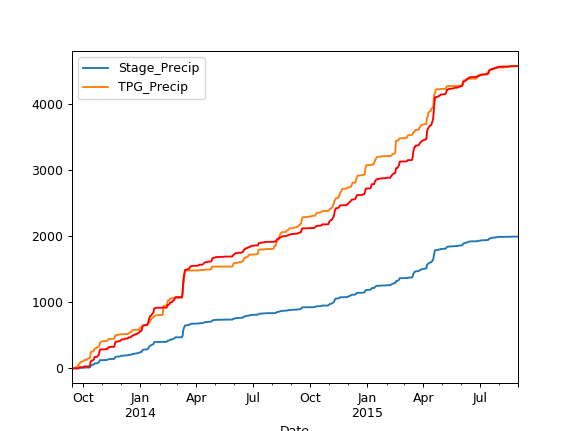

Scale factor = 2.29372051616


In [17]:
if precip_gage_change:
    daily_dat[precip_cols][start_good_overlap_precip_date: daily_dat[precip_cols[0]].last_valid_index()].cumsum().plot()
    ratiodf=daily_dat[precip_cols][start_good_overlap_precip_date: daily_dat[precip_cols[0]].last_valid_index()].cumsum()[-1:]
    scale_factor=(ratiodf.TPG_Precip/ratiodf.Stage_Precip).values[0]
    print("Scale factor = " + str(scale_factor))
    
    adjusted_stage=daily_dat.Stage_Precip.copy()*scale_factor
    adjusted_stage[start_good_overlap_precip_date: daily_dat[precip_cols[0]].last_valid_index()].cumsum().plot(color='red')

In [18]:
# date='2001-03-05'
# GUI_dat[date:date]

In [19]:
#dat[date:date]

In [20]:
#dat_m=GUI_dat[['temp_original', 'precip_original']].merge(dat[[temp_col]+ precip_cols+[wind_col]+temp_maxmin_cols], left_index=True, right_index=True, how='outer')


In [21]:
# date='2009-05-25'
# dat_m[['precip_original', 'Stage_Precip']][date:date]

In [22]:
# dat_m['GUItoNewPrecipFactor']=dat_m.Stage_Precip/dat_m.precip_original

In [23]:
#dat_m.GUItoNewPrecipFactor.dropna().plot(kind='hist')

In [24]:
# plt.figure()
# dat_m[['precip_original', 'Stage_Precip']]['2007-10':'2011-09'].cumsum().plot()

### Bias-adjust stage gage data to match TPG

<IPython.core.display.Javascript object>


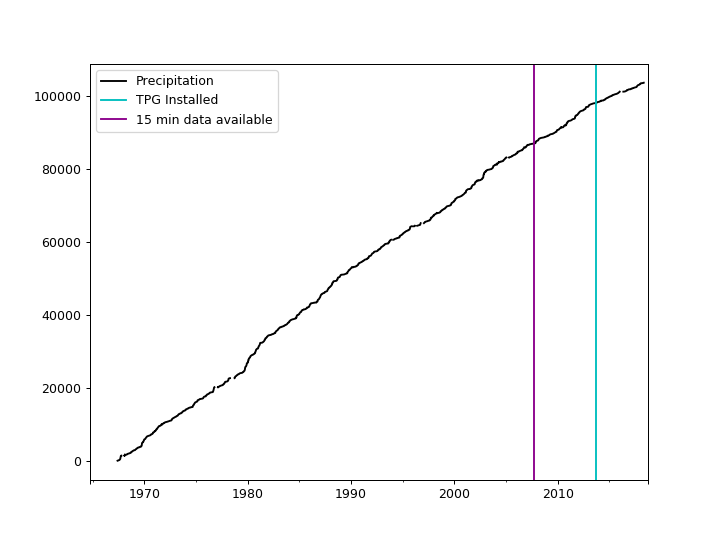

In [25]:
if precip_gage_change:
    #Merge older pre-digital data with new 15-min derived daily data
    dat=GUI_dat[['temp_original', 'precip_original']].merge(dat[[temp_col]+ precip_cols+[wind_col]+temp_maxmin_cols], left_index=True, right_index=True, how='outer')

    #Bias adjustment
    dat['Precipitation']=pd.np.nan
    dat['stage_adjusted']=dat.Stage_Precip*scale_factor #Adjusted by factor of 5 to account for orifice size, and *2 for wind factor (empirical)
    dat['original_adjusted']=dat.precip_original*scale_factor
    #Create full record from 3 pieces
    dat.loc[start_good_overlap_precip_date:,'Precipitation']=dat.loc[start_good_overlap_precip_date:,'TPG_Precip'] #precip is TPG from install -> end
    dat.loc[dat.stage_adjusted.first_valid_index():start_good_overlap_precip_date,'Precipitation']=dat.loc[dat.stage_adjusted.first_valid_index():start_good_overlap_precip_date,'stage_adjusted']#precip is adjusted stage (made from 15 min) back to late 2003
    dat.loc[:dat.stage_adjusted.first_valid_index(),'Precipitation']=dat.loc[:dat.stage_adjusted.first_valid_index(),'original_adjusted']#precip is adjusted stage (made from 15 min) back to late 2003

    #How does this look for a continuous precip record
    plt.figure(figsize=(8,6))
    dat.Precipitation.cumsum().plot(color='black')
    plt.axvline(x=start_good_overlap_precip_date, color='c', label="TPG Installed")
    plt.axvline(x=dat.stage_adjusted.first_valid_index(), color='darkmagenta',label="15 min data available")
    plt.legend()
    if save_plots:
        strFile = './figs/' + Glacier+Station+ '/precip_match/' + Glacier + Station+ '_Different_Eras_Of_Precip_Record.jpg'
        if os.path.isfile(strFile):
           os.system("rm "+strFile)
        plt.savefig(strFile)

In [26]:
start_good_overlap_precip_date

'2013-09-13'

In [27]:
# import plot_funcs

# plot_funcs.OLS_plot('temp_original', 'Temp_USGS', dat, title='original GUI temps vs new')


In [28]:
#dat['temp_diff']=dat.Temp_USGS - dat.temp_original

In [29]:
# diff_to_plot=dat[abs(dat.temp_diff)>0.5]
# diff_to_plot.head(1)

In [30]:
# plt.figure()
# dat.temp_diff.hist(bins=100)

In [31]:
# #plt.figure()
# time_lim='2002'
# ax=raw_dat[['Tpassive1', 'Tpassive2', 'TAspirated1', 'TAspirated2']][time_lim].plot(ylim=[-30, 25], color=['grey', 'grey', 'darkgrey', 'darkgrey'])
# old=dat.temp_original[time_lim].plot(ax=ax ,color='cyan')
# new=dat.Temp_USGS[time_lim].plot(ax=ax, color='purple')
# #diff_to_plot.temp_diff[time_lim].plot(ax=ax, color='red')
# diffpt=diff_to_plot.temp_original[time_lim].plot(ax=ax, style='.', color='red')
# #ax.legend([3:5])

In [32]:
# pth1=base_path + "Data/" +Glacier+ r"/AllYears/Wx/LVL1/" + Glacier.lower()+Station+"_15minall"+".csv"
# dat1=pd.read_csv(pth1)
# dat1['local_time']=pd.to_datetime(dat1["Local_time"], infer_datetime_format=True)
# dat1=dat1.set_index('local_time') #set this local time as the index

In [33]:
# dat1[['TPGCumulative', 'StageCumulative']].plot()

In [34]:
#Create single continuous temperature record
dat['Temperature']=dat[temp_col]
if need_to_append_historical_program_data:
    dat.loc[(dat.Temp_USGS.isnull()) & (dat.index<start_date_15min_data), 'Temperature']=dat.loc[(dat.Temp_USGS.isnull()) & (dat.index<start_date_15min_data), 'temp_original']

## Save data

In [35]:
dat.head()

,temp_original,precip_original,Temp_USGS,Stage_Precip,TPG_Precip,WindSpeed,Temp_min,Temp_max,Precipitation,stage_adjusted,original_adjusted,Temperature
1964-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


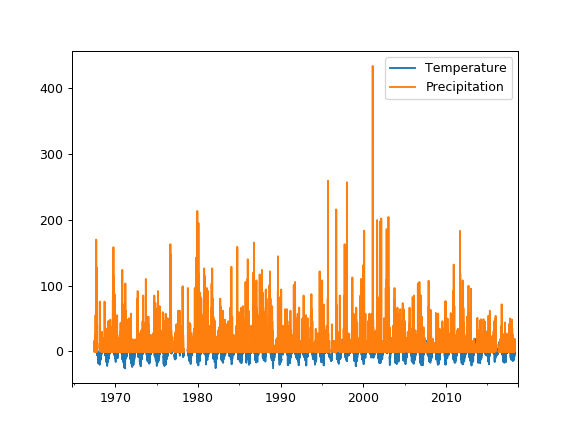

In [36]:
save_dat=dat[['Temperature', 'Precipitation']]
save_dat.plot()

In [37]:
if save_data:
    save_dat.loc[:,'Temperature']=["%.1f" %x for x in save_dat.Temperature]
    save_dat.loc[:,'Precipitation']=["%.1f" %x for x in save_dat.Precipitation]
    save_dat.index.name='Date'
    save_pth=base_path + '/Data/' + Glacier + '/AllYears/Wx/LVL3/Input_' + Glacier + '_Daily_Weather.csv'
    save_dat.to_csv(save_pth, float_format='%g', date_format='%Y/%m/%d') #write select data

C:\Users\ehbaker\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
#Define precip phase
dat=wx.define_precip_phase(dat, 'Temperature')

<IPython.core.display.Javascript object>


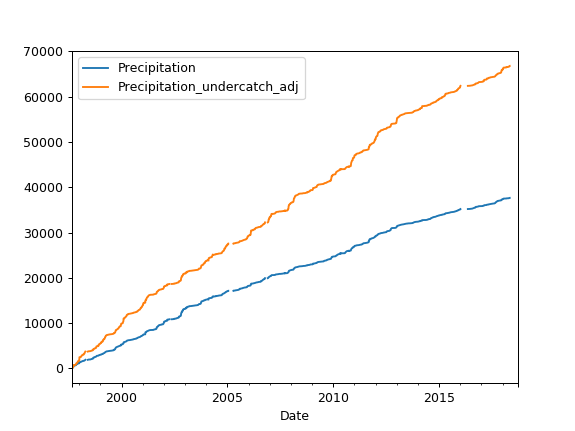

In [39]:
#Adjust recent data by wind speed, and save just this recent adjusted data
if wind_present:
    dat_recent=wx.define_precip_phase(dat[dat.WindSpeed.first_valid_index():].copy(), 'Temperature') #daily dat is a copy of original; original dat remains unedited

    #Calculate precip undercatch, using CONSTANT yearly pattern of wind speed
    dat_recent=wx.correct_undercatch_yang98(dat_recent, 'Precipitation', 'phase', 'WindSpeed', inplace=False)
    dat_recent[['Precipitation', 'Precipitation_undercatch_adj']].cumsum().plot()

    #Save this adjusted data
    if save_data:
        save_pth=base_path + '/Data/' + Glacier + '/AllYears/Wx/LVL3/OnlyRecentRealWindUndercatch_Adj' + Glacier + '_Daily_Weather.csv'
        dat_recent[dat.WindSpeed.first_valid_index():].to_csv(save_pth, float_format='%g', date_format='%Y/%m/%d') #write select data

### Calculate average wind-speeds, and adjust precipitation by this factor

<IPython.core.display.Javascript object>


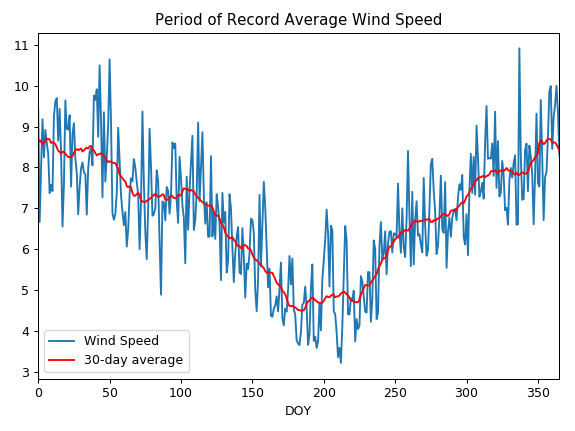

In [40]:
#Stuff to make period-of-record average for Wind Speed!
#Create period-of-record daily average (e.g. avg. on Mar1, Jan3, etc.)
if wind_present:
    n_window=30
    period_of_record_avg_ws=pd.DataFrame(dat[wind_col].groupby([dat.index.month, dat.index.day]).mean())
    period_of_record_avg_ws=period_of_record_avg_ws.reset_index()
    period_of_record_avg_ws.columns=['month', 'day', wind_col]

    period_of_record_avg_ws.index.name='DOY'
    period_of_record_avg_ws=period_of_record_avg_ws.reset_index()

    period_of_record_avg_ws_r30=period_of_record_avg_ws[wind_col].rolling(n_window, center=True).mean()

    #Calculate avg wind speed for periods before and after the moving-window won't b/c DOY 1-365 disconnect
    extra_ws=period_of_record_avg_ws.copy()
    extra=extra_ws[wind_col][0:n_window]
    extra_for_movavg=period_of_record_avg_ws.WindSpeed.append(extra, ignore_index=True)
    long_windowavg=extra_for_movavg.rolling(n_window, center=True).mean()
    period_of_record_avg_ws_r30[0:int(n_window/2)]=long_windowavg[366:(366+int(n_window/2))] #replace missing portion at beginning
    period_of_record_avg_ws_r30[int(366-(n_window/2)):366]=long_windowavg[366:int(366+(n_window/2))] #replace missing portion at end

    #Make Plot of this
    plt.figure()
    period_of_record_avg_ws.index.name='DOY'
    ax=period_of_record_avg_ws['WindSpeed'].plot()
    period_of_record_avg_ws_r30.plot(ax=ax, color='red')
    plt.legend(['Wind Speed', '30-day average'])
    plt.title('Period of Record Average Wind Speed')
    plt.tight_layout()
    plt.savefig('./figs/' + Glacier + Station+ '/trends/' + Glacier + Station+ 'PeriodOfRecordWindSpeed.jpg')

    #Add wind speed on day of year to main dataframe
    dat['DOY']=dat.index.dayofyear-1
    period_of_record_avg_ws_r30.index.name="DOY"
    period_of_record_avg_ws_r30.name='WS_Constant'
    period_of_record_avg_ws_r30=period_of_record_avg_ws_r30.reset_index()

<IPython.core.display.Javascript object>


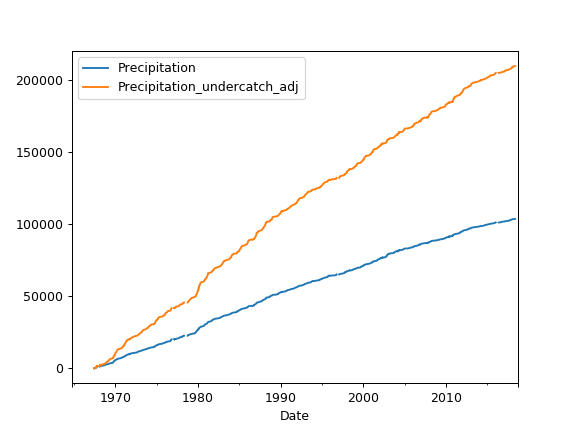

In [42]:
if wind_present:
    small_dat=dat[['Precipitation', 'Temperature', 'DOY', 'WindSpeed', 'phase']+ temp_maxmin_cols].copy()
    small_dat.index.name='Date'
    small_dat.reset_index(inplace=True)
    dat_adj=small_dat.merge(period_of_record_avg_ws_r30, how='left', left_on='DOY', right_on='DOY')

    dat_adj=dat_adj.set_index('Date')

    #Calculate precip undercatch, using CONSTANT yearly pattern of wind speed
    dat_adj=wx.correct_undercatch_yang98(dat_adj, 'Precipitation', 'phase', 'WS_Constant', inplace=False)
    dat_adj[['Precipitation', 'Precipitation_undercatch_adj']].cumsum().plot()

    #Rename this column
    dat_adj.rename(columns={'Precipitation_undercatch_adj':'Precip_AvgWindSpeed_UndercatchAdj'}, inplace=True)

    #Make another, using the REAL daily wind speed
    dat_adj=wx.correct_undercatch_yang98(dat_adj, 'Precipitation', 'phase', 'WindSpeed', inplace=False)
    dat_adj.rename(columns={'Precipitation_undercatch_adj':'Precip_MeasuredWindSpeed_UndercatchAdj'}, inplace=True)
    #Set to NAN before wind speed measured (in fucntion, NANs are filled to keep precip where recorded but wind down)
    dat_adj.loc[:dat_adj.WindSpeed.first_valid_index(),'Precip_MeasuredWindSpeed_UndercatchAdj']=pd.np.nan

In [43]:
if wind_present:
    #Save this adjusted data
    save_pth=base_path + '/Data/' + Glacier + '/AllYears/Wx/LVL3/Undercatch_Adj' + Glacier + '_Daily_Weather.csv'
    dat_adj.to_csv(save_pth, float_format='%g', date_format='%Y/%m/%d') #write select data
else:
    dat_adj=dat.copy() 
    print("no wind to adjust for undercatch")

In [44]:
if wind_present:
    precip_col='Precip_AvgWindSpeed_UndercatchAdj'
else:
    precip_col='Precipitation'
dat_adj['snow']=pd.np.nan #dat_adj.loc[dat_adj.phase=='snow', precip_col]
dat_adj['rain']=pd.np.nan #dat_adj.loc[dat_adj.phase=='rain', precip_col]

dat_adj['scale_factor_for_mixed_Fsnow']=pd.np.nan
dat_adj.loc[dat_adj.phase=='mixed', 'scale_factor_for_mixed_Fsnow']=((dat_adj.loc[dat_adj.phase=='mixed', 'Temperature'])/-4 + 0.75)
dat_adj.loc[dat_adj.phase=='rain', 'scale_factor_for_mixed_Fsnow']=0
dat_adj.loc[dat_adj.phase=='snow', 'scale_factor_for_mixed_Fsnow']=1

dat_adj['snow']=dat_adj[precip_col]*dat_adj.scale_factor_for_mixed_Fsnow

dat_adj['rain']=dat_adj[precip_col]*(1-dat_adj.scale_factor_for_mixed_Fsnow)

dat_adj['fSnow']=dat_adj.snow/dat_adj[precip_col]

In [45]:
#add numeric date
dat_adj['decimal_date']=dat_adj.index.year+ (dat_adj.index.dayofyear -1)/365

In [46]:
save_pth=base_path + '/Data/' + Glacier + '/AllYears/Wx/LVL3/RainSnowFractionData_' + Glacier + Station+ '.csv'
save_cols=['Precipitation', 'Temperature','phase','snow', 'rain','decimal_date']
if wind_present:
    save_cols=save_cols+['WindSpeed', 'WS_Constant', 'Precip_AvgWindSpeed_UndercatchAdj', 'Precip_MeasuredWindSpeed_UndercatchAdj']
dat_adj[save_cols].to_csv(save_pth)

In [32]:
#dat_adj_og=dat_adj.copy()
#dat_adj=dat_adj_og.copy()

In [33]:
# #Aggregate monthly data & plot

# #FIRST! Subset to only winter months (following Harpold 2012 trend paper)
# dat_adj['month']=dat_adj.index.month
# dat_adj=dat_adj[dat_adj.month.isin([6,7,8])]#isin([11,12,1,2,3])]


# mth_dat=pd.DataFrame()
# mth_dat['snow']=wx.aggregate_time_with_threshold(dat_adj['snow'], 'M', func='sum', steps_in_period=30)
# mth_dat['rain']=wx.aggregate_time_with_threshold(dat_adj['rain'], 'M', func='sum', steps_in_period=30)
# mth_dat['Precipitation']=wx.aggregate_time_with_threshold(dat_adj['Precipitation'], 'M', func='sum', steps_in_period=30)

# #calculate snow fraction
# mth_dat['fSnow']=mth_dat['snow']/(mth_dat['rain']+mth_dat['snow'])

# #Add decimal date
# mth_dat['decimal_date']=mth_dat.index.year+ (mth_dat.index.dayofyear -1)/365

In [34]:
# mth_dat.tail()
# import plot_funcs

In [35]:
# plot_funcs.OLS_plot('decimal_date', 'Precipitation', dat=mth_dat.dropna(subset=['Precipitation']), title='Monthly '+ 'fSnow, Nov-Mar', aspect=2.5)
# plt.savefig('./figs/trends/' + Glacier + Station+ '_Monthly_fSnowTrend_WINTER' +'.jpg')

In [36]:
# dat_adj.tail()

In [37]:
# #Aggregate yearly data & plot

# dat_adj['month']=dat_adj.index.month
# dat_adj=dat_adj[dat_adj.month.isin([11,12,1,2,3])]

# yr_dat=pd.DataFrame()
# yr_dat['snow']=wx.aggregate_time_with_threshold(dat_adj['snow'], 'AS', func='sum', steps_in_period=150)
# yr_dat['rain']=wx.aggregate_time_with_threshold(dat_adj['rain'], 'AS', func='sum', steps_in_period=150)

# #calculate snow fraction
# yr_dat['fSnow']=yr_dat['snow']/(yr_dat['rain']+yr_dat['snow'])

# #Add decimal date
# yr_dat['decimal_date']=yr_dat.index.year+ (yr_dat.index.dayofyear -1)/365


# plot_funcs.OLS_plot('decimal_date', 'fSnow', dat=yr_dat.dropna(subset=['fSnow']), title='Yearly '+ 'fSnow', aspect=2.5)
# #plt.savefig('./figs/trends/' + Glacier + Station+ '_Yearly_fSnowTrend' +'.jpg')

Trend Analysis

In [ ]:
# import plot_funcs
# import CleanWxData
# import seaborn as sns
# import statsmodels.api as sm
# sns.set_palette("Set2")
# sns.set(style='whitegrid') #set seaborn figure size to A4 paper

In [ ]:
# dat['decimal_date']=dat.index.year+ (dat.index.dayofyear -1)/365

In [ ]:
dat.head(1)

In [ ]:
dat.columns

In [ ]:
# #Simple  OLS plot of old vs new precip
# #var='Precipitation'
# var='Temperature'
# if var=='Temperature':
#     var_old='temp_original'
#     agg_func='mean'
# if var=='Precipitation':
#     var_old='precip_original'
#     agg_func='sum'
# sns.set(rc={'figure.figsize':(12, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
# fig=plot_funcs.OLS_plot(var_old, var, dat=dat.dropna(subset=[var]), title='Daily '+ var, aspect=2.5)
# if save_plots:
#     plt.savefig('./figs/precip_match/' + Glacier + Station+ '_Compare2preciprecords_'+ var +'.jpg')

In [ ]:
# #Aggregate monthly data
# mth_dat=pd.DataFrame()
# mth_dat[var]=wx.aggregate_time_with_threshold(dat[var], 'M', func=agg_func, steps_in_period=30)

# #Add decimal date
# mth_dat['decimal_date']=mth_dat.index.year+ (mth_dat.index.dayofyear -1)/365

In [ ]:
# print(len(mth_dat[var]['1967':][mth_dat[var]['1967':].isnull()]))

# len(mth_dat[var]['1967':][mth_dat[var]['1967':].notnull()])

In [ ]:
# #Simple  OLS plot of monthly data
# sns.set(rc={'figure.figsize':(6, 12)}, style='whitegrid') #set seaborn figure size to A4 paper
# fig=plot_funcs.OLS_plot('decimal_date', var, dat=mth_dat.dropna(subset=[var]), title='Monthly '+ var + "; "+ agg_func, aspect=2.5)
# #if save_plots:
# plt.savefig('./figs/trends/' + Glacier + Station+ '_OLS_MonthlyTrend21_'+ var +'.jpg')

In [ ]:
# #Aggregate to yearly data
# y_dat=pd.DataFrame()
# y_dat[var]=wx.aggregate_time_with_threshold(dat[var], 'AS', func=agg_func, steps_in_period=365)
# #Add decimal date
# y_dat['decimal_date']=y_dat['decimal_date']=y_dat.index.year+ (y_dat.index.dayofyear -1)/365

# #y_dat.loc['1978':'1981', 'Precipitation']=pd.np.nan #see what happens w/o 1980 PDO bump

# #Simple  OLS plot
# sns.set(rc={'figure.figsize':(12, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
# fig=plot_funcs.OLS_plot('decimal_date', var, dat=y_dat.dropna(subset=[var]), title='Yearly '+ var + "; "+ agg_func, aspect=2.5)
# if save_plots:
#     plt.savefig('./figs/trends/' + Glacier + Station+ '_OLS_Annual_2'+ var +'.jpg')

In [ ]:
# mth_dat['month']=mth_dat.index.month
# mth_dat['year']=mth_dat.index.year
# g=sns.factorplot(x='year', y=var, hue='month', row='month', data=mth_dat, kind='point', aspect=5)
# plt.xticks(rotation=-90)
# if save_plots:
#     plt.savefig('./figs/trends/' + Glacier + Station+ '_ScatterByMonthThruTime_'+ var +'.jpg')

In [ ]:
# plt.figure()
# #sns.set(rc={'figure.figsize':(12, 6)}) #set seaborn figure size to A4 paper
# g=sns.boxplot(x=mth_dat.index.year, y=var, data=mth_dat)
# plt.xticks(rotation=-90)

In [ ]:
# #Find missing values and fill
# var_filled=dat[var].interpolate()
# var_filled=var_filled[var_filled.first_valid_index():]

# #Deal with adding dates to x-axis
# jan1s=var_filled.index[var_filled.index.dayofyear==1]
# jan1_labels=jan1s.year
# idx_jan1s=[var_filled.index.get_loc(x) for x in jan1s]


In [ ]:
# #Make decomposition plot
# decomposition= sm.tsa.seasonal_decompose(var_filled.values, model='additive', freq=365) #frequency is yearly, but must be integer
# fig = decomposition.plot()
# my_xticks=jan1_labels
# plt.xticks(idx_jan1s, my_xticks)
# plt.show()
# fig.autofmt_xdate()
# plt.savefig("./figs/seasonal_trend_decompositon_3"+ var+ "_"+ Glacier + Station+ ".jpg")

In [ ]:
# df=pd.DataFrame(decomposition.trend)
# df.columns=['trend']

In [ ]:
# df=df.reset_index()

In [ ]:
# df['year']=df.index/365

In [ ]:
# plot_funcs.OLS_plot("year", "trend", df)

In [ ]:
#Colored by date
f, ax = plt.subplots()
#cmap = sns.cubehelix_palette(as_cmap=True)
cmap=sns.diverging_palette(220, 20, n=7, as_cmap=True)
points = ax.scatter(dat.precip_original, dat.Precipitation, c=dat.index.year, s=50, cmap=cmap, alpha=0.7)
f.colorbar(points)
plt.xlabel="Original Precip"
plt.ylabel="New Precip"
if save_plots:
    plt.savefig('./figs/precip_match/' + Glacier + Station+ '_GUI vs New Colored by Year2.jpg')

In [ ]:
dat[['Precipitation', 'precip_original']].plot()

In [ ]:
#save_dat.to_csv(save_pth, float_format='%g', date_format='%Y/%m/%d') #write select data

In [ ]:
dat_adj['ratio']=dat_adj.Precipitation_undercatch_adj/dat_adj.Precipitation

In [ ]:
plt.figure()
dat_adj.ratio.plot(kind='hist', bins=50)

In [ ]:
#Aggregate Ratio yearly data
var='ratio'
y_dat=dat_adj.ratio.resample('AS', convention='start').agg(['median', 'count'])

#Add decimal date
y_dat['decimal_date']=y_dat['decimal_date']=y_dat.index.year+ (y_dat.index.dayofyear -1)/365

#y_dat.loc['1978':'1981', 'Precipitation']=pd.np.nan #see what happens w/o 1980 PDO bump

#Simple  OLS plot
sns.set(rc={'figure.figsize':(6, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
fig=plot_funcs.OLS_plot('decimal_date', 'median', dat=y_dat.dropna(subset=['median']), title='Precip Adjustment Ratio', aspect=2.5)
# if save_plots:
#     plt.savefig('./figs/trends/' + Glacier + Station+ '_trendInThePrecipAdjustmentFactor'+ var +'.jpg')

In [ ]:
dat.join(dat_adj, t)

In [ ]:
dat_adj.ratio.max()

In [ ]:
dat_adj[var]

In [ ]:
#Aggregate to yearly data
var='ratio'
#y_dat=dat_adj.ratio.resample('AS', convention='start').agg(['sum', 'count'])
y_dat=pd.DataFrame()
y_dat[var]=wx.aggregate_time_with_threshold(dat_adj[var], 'AS', func='median', steps_in_period=365, threshold=0.1)
#Add decimal date
y_dat['decimal_date']=y_dat['decimal_date']=y_dat.index.year+ (y_dat.index.dayofyear -1)/365

#y_dat.loc['1978':'1981', 'Precipitation']=pd.np.nan #see what happens w/o 1980 PDO bump

#Simple  OLS plot
sns.set(rc={'figure.figsize':(6, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
fig=plot_funcs.OLS_plot('decimal_date', var, dat=y_dat.dropna(subset=[var]), title='Precip Adjustment Ratio', aspect=2.5)
# if save_plots:
#     plt.savefig('./figs/trends/' + Glacier + Station+ '_trendInThePrecipAdjustmentFactor'+ var +'.jpg')

In [ ]:
y_dat.tail()

In [ ]:
sns.set(rc={'figure.figsize':(6, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
plt.figure()
dat_adj.ratio.plot(kind='hist', bins=50)
plt.title("Histogram of Wind Adjustment Factors")

In [ ]:
y_dat.dropna()

In [ ]:
#Aggregate to yearly data
var='Precipitation_undercatch_adj'
y_dat=pd.DataFrame()
y_dat[var]=wx.aggregate_time_with_threshold(dat_adj[var], 'AS', func='sum', steps_in_period=365)
#Add decimal date
y_dat['decimal_date']=y_dat['decimal_date']=y_dat.index.year+ (y_dat.index.dayofyear -1)/365

#y_dat.loc['1978':'1981', 'Precipitation']=pd.np.nan #see what happens w/o 1980 PDO bump

#Simple  OLS plot
sns.set(rc={'figure.figsize':(12, 6)}, style='whitegrid') #set seaborn figure size to A4 paper
fig=plot_funcs.OLS_plot('decimal_date', var, dat=y_dat.dropna(subset=[var]), title='Total Annual Precip', aspect=2.5)
if save_plots:
    plt.savefig('./figs/trends/' + Glacier + Station+ '_OLS_WindAdjustedYearly'+ var +'.jpg')

In [ ]:
save_plots

In [ ]:
dat.head()

In [ ]:
#Something is messed up in this block; must be mulitplying by scale factor a few times or something? Confusing.

# dat['Stage_Adj']=dat.Stage_Precip*scale_factor #digital data, 2003 -> present
# GUI_dat['precip_original']=GUI_dat.precip_original*scale_factor #pre-digital era

# dat[precip_cols+ ['Stage_Adj', 'precip_original']][start_good_overlap_precip_date:].cumsum().plot()

# ### Combine the 2 gages into a continous record of digital time (2003 -> present)
# dat['Precipitation']=dat['TPG_Precip']
# dat.loc[dat.index<start_good_overlap_precip_date, 'Precipitation']=pd.np.nan #set TPG records before final wind screen to NAN

# dat.loc[dat.Precipitation.isnull(), 'Precipitation']=dat.Stage_Adj #this is digital-era scaled precip

# #Plot to ensure that full digital precip record is captured as we want
# plt.figure()
# raw_data=(raw_dat.StageCumulative*1000*5*scale_factor)
# ax=raw_data.plot(color='grey')
# dat[['Precipitation', 'TPG_Precip', 'Stage_Precip', 'Stage_Adj']].cumsum().plot(ax=ax)

# plt.ylim(-10, 25000)

# Merge older data with new 15-min derived daily data
# dat=GUI_dat[['temp_original', 'precip_original']].merge(dat[[temp_col]+ precip_cols+['Precipitation']+ [wind_col]], left_index=True, right_index=True, how='outer')

# #Create single continuous precipitation record
# dat['Precip_All']=dat['Precipitation'] #this will hold precip from 2003-09-14 (first day of digital precip) _> present, and prior records before

# use_Mayo_data=dat.Precipitation.first_valid_index()-datetime.timedelta(days=1)
# dat.loc[:use_Mayo_data, "Precip_All"]=dat.loc[:use_Mayo_data, 'precip_original']